# Project: Prostate DataSet – Linear and Regularized Regression

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Step A: Read in Dataset and Examine Dataset and Display Statistics

In [3]:
pros_data = pd.read_csv('prostate_data.csv', index_col = 'id')
pros_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
id,,,,,,,,,
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [4]:
# what are the data types of variables in the dataset?
pros_data.dtypes

lcavol     float64
lweight    float64
age          int64
lbph       float64
svi          int64
lcp        float64
gleason      int64
pgg45        int64
lpsa       float64
dtype: object

In [5]:
# How many patients in the dataset? 
# How many variables in the dataset?
pros_data.shape

(97, 9)

In [6]:
# How are the variables distributed? 
pros_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


In [7]:
pros_data['gleason'].value_counts()

7    56
6    35
9     5
8     1
Name: gleason, dtype: int64

In [8]:
pros_data['svi'].value_counts()

0    76
1    21
Name: svi, dtype: int64

In [9]:
# some interesting facts from reading the results.
pros_data[pros_data.age == pros_data.age.min()]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
id,,,,,,,,,
19,-0.562119,3.267666,41,-1.386294,0,-1.386294,6,0,1.558145


In [10]:
# some interesting facts from reading the results.
pros_data[pros_data.lweight == pros_data.lweight.max()]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
id,,,,,,,,,
70,1.193922,4.780383,72,2.326302,0,-0.798508,7,5,2.972975


In [11]:
# Are there missing variables?
# count the number of NaN values in each column
pros_data.isnull().sum()

lcavol     0
lweight    0
age        0
lbph       0
svi        0
lcp        0
gleason    0
pgg45      0
lpsa       0
dtype: int64

### Step B: Examine the Relationship Between the Variables

In [12]:
pros_corr = pros_data.corr()
pros_corr

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652,0.734460
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354,0.433319
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460,0.179809
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648,0.566218
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528,0.548813
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000,0.422316
lpsa,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1.000000


In [13]:
grps = ['NegStrong','NegMedium','Weak','PosMedium','PosStrong']
cols = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45' ,'lpsa']
for col in cols:
    pros_corr[col] = pd.cut(pros_corr[col], 
        (-1,-0.65,-0.3,0.3, 0.65,1), labels = grps)
pros_corr

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,PosStrong,Weak,Weak,Weak,PosMedium,PosStrong,PosMedium,PosMedium,PosStrong
lweight,Weak,PosStrong,PosMedium,PosMedium,Weak,Weak,Weak,Weak,PosMedium
age,Weak,PosMedium,PosStrong,PosMedium,Weak,Weak,Weak,Weak,Weak
lbph,Weak,PosMedium,PosMedium,PosStrong,Weak,Weak,Weak,Weak,Weak
svi,PosMedium,Weak,Weak,Weak,PosStrong,PosStrong,PosMedium,PosMedium,PosMedium
lcp,PosStrong,Weak,Weak,Weak,PosStrong,PosStrong,PosMedium,PosMedium,PosMedium
gleason,PosMedium,Weak,Weak,Weak,PosMedium,PosMedium,PosStrong,PosStrong,PosMedium
pgg45,PosMedium,Weak,Weak,Weak,PosMedium,PosMedium,PosStrong,PosStrong,PosMedium
lpsa,PosStrong,PosMedium,Weak,Weak,PosMedium,PosMedium,PosMedium,PosMedium,PosStrong


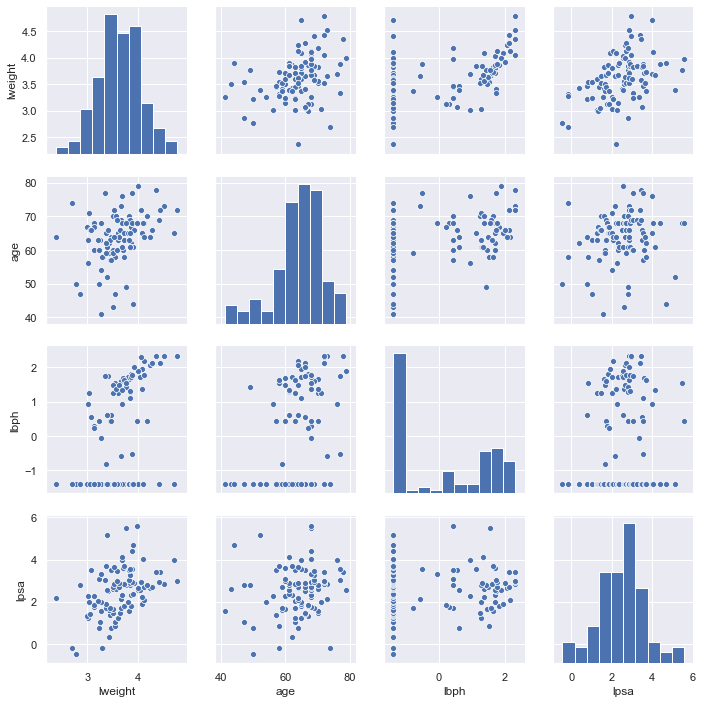

In [30]:
pros_data1 = pros_data.drop(['lcavol', 'svi', 'lcp', 'gleason', 'pgg45'], axis=1)
sns.pairplot(pros_data1, height=2.5);

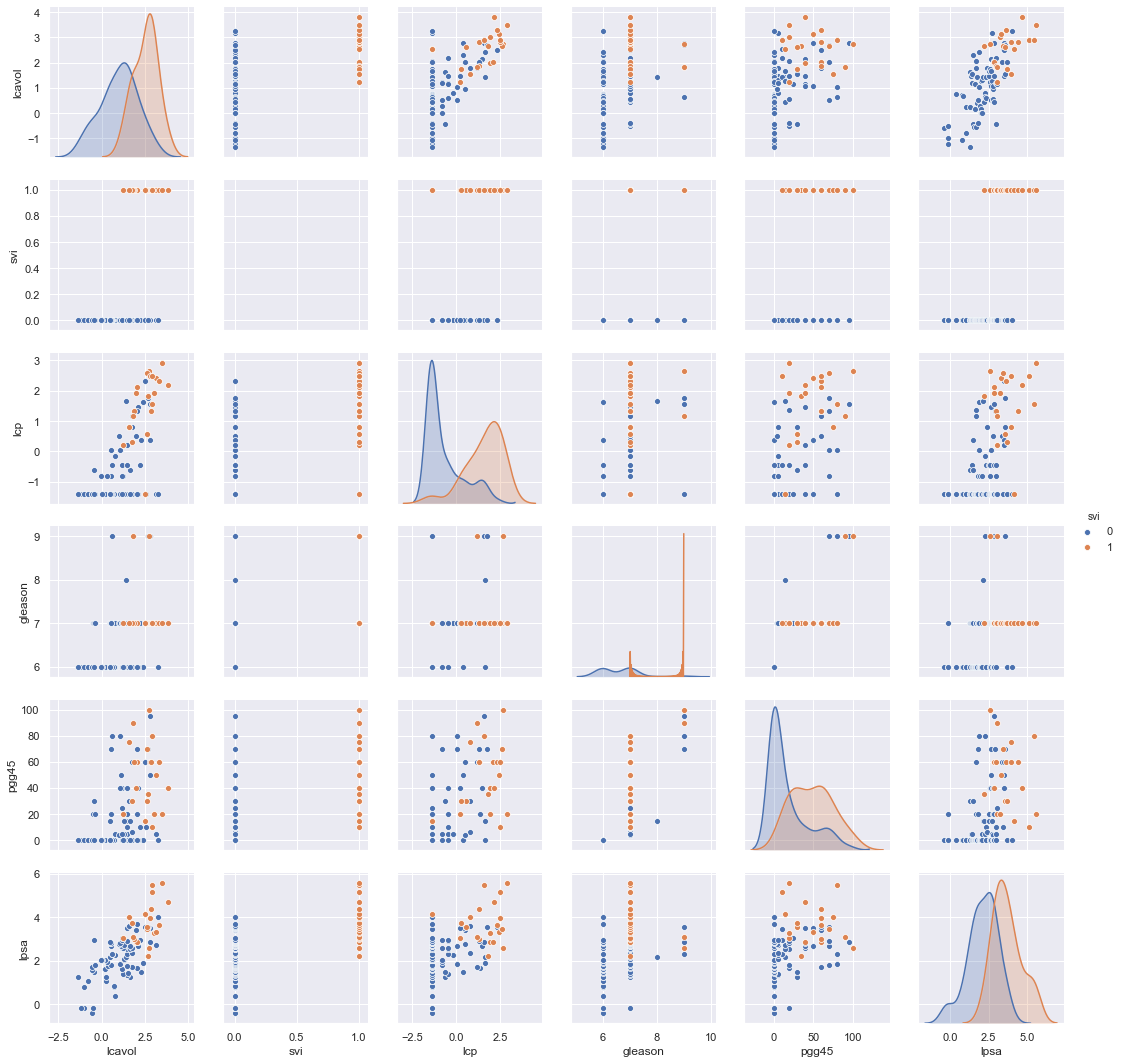

In [32]:
pros_data2 = pros_data.drop(['lweight', 'age', 'lbph'], axis=1)
sns.pairplot(pros_data2, hue = 'svi', height=2.5);

### Step C: Linear Regression Analysis using Stepwise Feature Selection

In [16]:
# The response variable is lpsa
Y = pros_data['lpsa']
X = pros_data.drop(['lpsa'], axis=1)
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_std0 = X_std
X_std = sm.add_constant(X_std)

In [17]:
pros_model0 = sm.OLS(Y, X_std)
pros_model0 = pros_model0.fit()
pros_model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     21.68
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           7.65e-18
Time:                        17:06:52   Log-Likelihood:                -98.248
No. Observations:                  97   AIC:                             214.5
Df Residuals:                      88   BIC:                             237.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     34.895      0.000       2.337       2.620
x1             0.6617      0.103      6.425      0.000       0.457       0.866
x2             0.2651      0.086      3.096      0.003       0.095       0.435
x3            -0.1574      0.082     -1.917      0.058      -0.321       0.006
x4             0.1396      0.084      1.670      0.098      -0.027       0.306
x5             0.3137      0.099      3.158      0.002       0.116       0.511
x6            -0.1475      0.125     -1.180      0.241      -0.396       0.101
x7             0.0354      0.112      0.317      0.752      -0.186       0.257
x8             0.1251      0.122      1.021      0.310      -0.118       0.368
==============================================================================
Omnibus:                        0.563   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.183
Skew:                           0.017   Prob(JB):                        0.913
Kurtosis:                       3.210   Cond. No.                         4.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
X_std1 = np.delete(X_std, [7], axis=1)
pros_model1 = sm.OLS(Y, X_std1)
pros_model1 = pros_model1.fit()
pros_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     25.01
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           1.54e-18
Time:                        17:06:52   Log-Likelihood:                -98.303
No. Observations:                  97   AIC:                             212.6
Df Residuals:                      89   BIC:                             233.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     35.073      0.000       2.338       2.619
x1             0.6678      0.101      6.634      0.000       0.468       0.868
x2             0.2619      0.085      3.096      0.003       0.094       0.430
x3            -0.1549      0.081     -1.905      0.060      -0.316       0.007
x4             0.1405      0.083      1.691      0.094      -0.025       0.306
x5             0.3099      0.098      3.159      0.002       0.115       0.505
x6            -0.1460      0.124     -1.175      0.243      -0.393       0.101
x7             0.1494      0.095      1.573      0.119      -0.039       0.338
==============================================================================
Omnibus:                        0.550   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.175
Skew:                           0.018   Prob(JB):                        0.916
Kurtosis:                       3.205   Cond. No.                         3.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
X_std2 = np.delete(X_std, [6,7], axis=1)
pros_model2 = sm.OLS(Y, X_std2)
pros_model2 = pros_model2.fit()
pros_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     28.83
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           5.29e-19
Time:                        17:06:53   Log-Likelihood:                -99.049
No. Observations:                  97   AIC:                             212.1
Df Residuals:                      90   BIC:                             230.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     34.999      0.000       2.338       2.619
x1             0.6138      0.090      6.840      0.000       0.436       0.792
x2             0.2622      0.085      3.094      0.003       0.094       0.431
x3            -0.1410      0.081     -1.749      0.084      -0.301       0.019
x4             0.1378      0.083      1.655      0.101      -0.028       0.303
x5             0.2619      0.089      2.930      0.004       0.084       0.439
x6             0.0989      0.085      1.165      0.247      -0.070       0.267
==============================================================================
Omnibus:                        0.353   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.141
Skew:                          -0.088   Prob(JB):                        0.932
Kurtosis:                       3.064   Cond. No.                         2.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
X_std3 = np.delete(X_std, [6,7,8], axis=1)
pros_model3 = sm.OLS(Y, X_std3)
pros_model3 = pros_model3.fit()
pros_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     34.19
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           1.65e-19
Time:                        17:06:53   Log-Likelihood:                -99.776
No. Observations:                  97   AIC:                             211.6
Df Residuals:                      91   BIC:                             227.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     34.931      0.000       2.337       2.619
x1             0.6379      0.088      7.289      0.000       0.464       0.812
x2             0.2507      0.084      2.972      0.004       0.083       0.418
x3            -0.1218      0.079     -1.540      0.127      -0.279       0.035
x4             0.1461      0.083      1.758      0.082      -0.019       0.311
x5             0.2944      0.085      3.461      0.001       0.125       0.463
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.290
Skew:                          -0.134   Prob(JB):                        0.865
Kurtosis:                       3.005   Cond. No.                         2.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
X_std4 = np.delete(X_std, [3,6,7,8], axis=1)
pros_model4 = sm.OLS(Y, X_std4)
pros_model4 = pros_model4.fit()
pros_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     41.53
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           7.54e-20
Time:                        17:06:53   Log-Likelihood:                -101.02
No. Observations:                  97   AIC:                             212.0
Df Residuals:                      92   BIC:                             224.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.071     34.673      0.000       2.336       2.620
x1             0.6197      0.087      7.094      0.000       0.446       0.793
x2             0.2285      0.084      2.729      0.008       0.062       0.395
x3             0.1134      0.081      1.401      0.165      -0.047       0.274
x4             0.2906      0.086      3.392      0.001       0.120       0.461
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.277
Skew:                          -0.122   Prob(JB):                        0.871
Kurtosis:                       2.906   Cond. No.                         1.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X_std5 = np.delete(X_std, [3,4,6,7,8], axis=1)
pros_model5 = sm.OLS(Y, X_std5)
pros_model5 = pros_model5.fit()
pros_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     54.15
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           2.44e-20
Time:                        17:06:53   Log-Likelihood:                -102.05
No. Observations:                  97   AIC:                             212.1
Df Residuals:                      93   BIC:                             222.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4784      0.072     34.495      0.000       2.336       2.621
x1             0.6166      0.088      7.024      0.000       0.442       0.791
x2             0.2820      0.075      3.768      0.000       0.133       0.431
x3             0.2742      0.085      3.214      0.002       0.105       0.444
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.215
Skew:                          -0.069   Prob(JB):                        0.898
Kurtosis:                       2.815   Cond. No.                         1.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#Interpretation of Model
#lpsa = 2.4784 + 0.6166 * lcavol + 0.2820 * lweight + 0.2742 * svi

### Step D: Linear Regression Analysis on Best Model

In [24]:
Y = pros_data['lpsa']
X_stdB = np.delete(X_std0, [2,3,5,6,7], axis=1) 

In [25]:
# Create 6 different random splits of the predictor matrix into 
# 80% train and 20% test using this list [0, 5, 10, 15, 20, 25]
# Train the model on 80% and test it on 20% of the records 
# Capture the coefficients and intercept from each run.
# Capture the R-squ and MSE scores of each run 
# This will tells us how good the model is with unseen data
# Calculate the mean of the R-squ and MSE scores
# Display each of the things captured and calculated
R2_scores_list = []
RMSE_scores_list = []
coeff_list = []
intercept_list = []
for rs in [0, 5, 10, 15, 20, 25]:
    # Fit the model to produce a set of predictions 
    # using random_state = rs
    lr = LinearRegression()  
    X_train, X_test, Y_train, Y_test = train_test_split(X_stdB, Y, random_state = rs, test_size=0.2)
    model = lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    coeff_list.append(model.coef_)
    intercept_list.append (model.intercept_)
    R2_scores_list.append (model.score(X_test, Y_test))
    RMSE_scores_list.append ( np.sqrt(
             metrics.mean_squared_error(Y_test, Y_pred)))
print ('Coefficients:', coeff_list)
print() 
print ('Intercepts:', intercept_list) 
print()
print ('R-Squared Scores:', R2_scores_list)
print() 
print ('RMSE:', RMSE_scores_list) 
print()
print ('Mean R-Squared Score:', sum(R2_scores_list) / len (R2_scores_list))
print()
print ("Mean RMSE:", sum(RMSE_scores_list) / len (RMSE_scores_list))

Coefficients: [array([0.66640693, 0.23104859, 0.25078784]), array([0.64573699, 0.36840732, 0.28152755]), array([0.57403644, 0.25285829, 0.28447265]), array([0.66101933, 0.28367839, 0.16031478]), array([0.56211517, 0.24708144, 0.3242034 ]), array([0.59748088, 0.28206767, 0.28400069])]

Intercepts: [2.452391956063055, 2.484470889780372, 2.464910044533579, 2.4402939935503314, 2.5126326492375823, 2.480746366784857]

R-Squared Scores: [0.5986531838882418, -0.7803906105730822, 0.7266779416714848, 0.6198279576885348, 0.7093868229848495, 0.56297348383231]

RMSE: [0.6598016190399036, 0.7555593401063059, 0.6661960779564673, 0.6783483563040816, 0.712449354848658, 0.8545086968315395]

Mean R-Squared Score: 0.4061881299153898

Mean RMSE: 0.7211439075144925


5- Modify the above code snippet to run the regression on 50 different train test splits using random states 0-49.  Report only the mean of the R2-squared values and the mean of the RMSE values. 

In [26]:
R2_scores_list = []
RMSE_scores_list = []
coeff_list = []
intercept_list = []
for rs in range(50):
    # Fit the model to produce a set of predictions 
    # using random_state = rs
    lr = LinearRegression()  
    X_train, X_test, Y_train, Y_test = train_test_split(X_stdB, Y, random_state = rs, test_size=0.2)
    model = lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    coeff_list.append (model.coef_)
    intercept_list.append (model.intercept_)
    R2_scores_list.append (model.score(X_test, Y_test))
    RMSE_scores_list.append ( np.sqrt(
             metrics.mean_squared_error(Y_test, Y_pred)))
print ('Mean R-Squared Score:', sum(R2_scores_list) / len (R2_scores_list))
print()
print ("Mean RMSE:", sum(RMSE_scores_list) / len (RMSE_scores_list))

Mean R-Squared Score: 0.521923383711318

Mean RMSE: 0.7434206455417481


### Step E: Regularized Regression Analysis on Full Model 

In [27]:
Y = pros_data['lpsa']
X = pros_data.drop(['lpsa'], axis=1)

In [28]:
for rs in [0, 5, 10, 25]:        
    alpha_range = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = rs, test_size=0.2)
    ridcvmod = RidgeCV (alphas=alpha_range, normalize=True,
                        scoring='neg_mean_squared_error')
    ridcvmod.fit (X_train, Y_train)
    Y_pred = ridcvmod.predict (X_test)
    print("Random State: ", rs)
    print("RidgeCV Regression Best Alpha", ridcvmod.alpha_)
    print("RidgeCV Regression Coefficients", ridcvmod.coef_) 
    print ("RidgeCV Regression Test R-squared", ridcvmod.score(X_test, Y_test))
    print ("RidgeCV Regression MSE", metrics.mean_squared_error(Y_pred, Y_test)) 
    print()

Random State:  0
RidgeCV Regression Best Alpha 0.01
RidgeCV Regression Coefficients [ 0.64907384  0.49867945 -0.02594277  0.11602661  0.76728483 -0.15446851
  0.13501424  0.00212503]
RidgeCV Regression Test R-squared 0.5141531991697965
RidgeCV Regression MSE 0.5269947383035848

Random State:  5
RidgeCV Regression Best Alpha 0.1
RidgeCV Regression Coefficients [ 0.48090545  0.74777504 -0.01161293  0.0871472   0.64227008 -0.00987548
  0.03507999  0.00508594]
RidgeCV Regression Test R-squared -0.6488147736345589
RidgeCV Regression MSE 0.5286810357402063

Random State:  10
RidgeCV Regression Best Alpha 0.1
RidgeCV Regression Coefficients [ 0.44046049  0.47975202 -0.02004489  0.12434931  0.63817435  0.01434752
  0.10404343  0.00157294]
RidgeCV Regression Test R-squared 0.6680124726719927
RidgeCV Regression MSE 0.5390775280158571

Random State:  25
RidgeCV Regression Best Alpha 0.1
RidgeCV Regression Coefficients [ 0.42957061  0.62913288 -0.00973576  0.05433603  0.63370661 -0.00426519
  0.11

In [35]:
#suppress all FutureWarnings by adding two line codes below
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [36]:
Y = pros_data [['lpsa']]
X = pros_data.drop(['lpsa'], axis=1)
Y = Y.values
Y = Y.ravel()

for rs in [0, 5, 10, 25]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=rs, test_size=0.2)
    lascvmod = LassoCV (n_alphas=100, normalize=True, random_state=rs)
    lascvmod.fit(X_train, Y_train)
    Y_pred = lascvmod.predict(X_test)
    print("Random State: ", rs)
    print("LassoCV Regression Best Alpha", lascvmod.alpha_)
    print("LassoCV Regression Coefficients", lascvmod.coef_) 
    print ("LassoCV Regression Test R-squared", lascvmod.score(X_test, Y_test))
    print ("LassoCV Regression MSE", metrics.mean_squared_error(Y_pred, Y_test))
    print()

Random State:  0
LassoCV Regression Best Alpha 0.00010015692649299805
LassoCV Regression Coefficients [ 0.66214429  0.49517079 -0.02649698  0.11772437  0.77766499 -0.16474115
  0.13651317  0.0021229 ]
LassoCV Regression Test R-squared 0.5041896928039723
LassoCV Regression MSE 0.537802086259507

Random State:  5
LassoCV Regression Best Alpha 0.007789379247456696
LassoCV Regression Coefficients [ 0.51354726  0.65719955 -0.          0.03804914  0.53017493  0.
  0.          0.00304057]
LassoCV Regression Test R-squared -0.583548005630002
LassoCV Regression MSE 0.5077536986858426

Random State:  10
LassoCV Regression Best Alpha 8.937850970155124e-05
LassoCV Regression Coefficients [ 0.52737173  0.481621   -0.02616403  0.15052643  0.71594592 -0.04320033
  0.11301348  0.00160713]
LassoCV Regression Test R-squared 0.6800457809366989
LassoCV Regression MSE 0.5195379804750198

Random State:  25
LassoCV Regression Best Alpha 0.003445849299330506
LassoCV Regression Coefficients [ 0.46712297  0.596